Objectivs :
* Use part1 learning against real data from kaggle

Note I'll simulate the quantum computing part

# Environnement set up

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

from zipfile import ZipFile
import pandas as pd
import time
import warnings
warnings.simplefilter(action='ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
#from qiskit_machine_learning.datasets import ad_hoc_data
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC
from qiskit_machine_learning.algorithms import QSVC
#from sklearn.cluster import SpectralClustering
#from sklearn.metrics import normalized_mutual_info_score
#from sklearn.decomposition import KernelPCA
#from sklearn.linear_model import LogisticRegression
#
#from qiskit.utils import algorithm_globals
#
#algorithm_globals.random_seed = 12345

# Personal functions

In [2]:
def drawConfusionMatrix(y_test, y_pred):
    '''
    drawConfusionMatrix(y_test, y_pred)
    Input : y_test : list of real target.
            y_pred : list of predicted target.

    This fonction draw a confusion matrix from y_test and y_pred.
    '''
    cf_matrix = confusion_matrix(y_test, y_pred)
    cm_sum = np.sum(cf_matrix, axis=1, keepdims=True)
    cm_perc = cf_matrix / cm_sum.astype(float) * 100
    annot = np.empty_like(cf_matrix).astype(str)
    nrows, ncols = cf_matrix.shape
    labels = ["Died", "Survived"]
    sns.heatmap(cf_matrix/np.sum(cf_matrix), 
                xticklabels=labels, 
                yticklabels=labels, 
                annot=True)
    plt.yticks(rotation=0)
    plt.ylabel('Predicted values', rotation=0)
    plt.xlabel('Actual values')
    plt.show()

# Import data

In [3]:
scores = {}
# starting with titanic data
api.competition_download_files('titanic', path="DATA/")

# unzip
zf = ZipFile('DATA/titanic.zip')
zf.extractall('DATA/') #save files in selected folder
zf.close()

df_train = pd.read_csv("DATA/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Preprocessing data

In [4]:
start_time = time.time()
df_train = df_train.drop(["PassengerId", "Ticket", "Cabin", "SibSp", "Parch", "Embarked", "Name"],axis=1) # Remove unique ID and not relevant feature to optimize the quantum computing part

# Computing mean values to replace missing ones.
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].mean())

# Transforming gender
df_train["Sex"].loc[df_train["Sex"] == "male"] = 0
df_train["Sex"].loc[df_train["Sex"] == "female"] = 1
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

This calculations took me : 00:00:00


# Train/Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(["Survived"], axis=1), 
                                                    df_train["Survived"], 
                                                    test_size=0.2,
                                                    random_state=0)

# SVC Classification

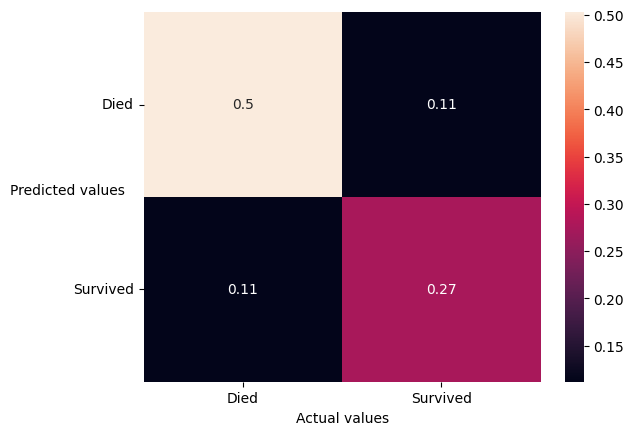

Perfomance is : 77.65% for SVM as a baseline
This calculations took me : 00:00:00


In [6]:
start_time = time.time()
# Using classical ML technics to obtain a base line
clf = SVC(kernel='linear', C = 1.0, tol=1e-2, cache_size=20000, max_iter=10000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

drawConfusionMatrix(y_test, y_pred)

score = (((y_pred == y_test).sum())/y_test.shape[0])
score = round(score*100,2)
print("Perfomance is : {}% for SVM as a baseline".format(score))
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

scores["classical_SVC"] = {}
scores["classical_SVC"]["score"] = score
scores["classical_SVC"]["time"] = elapsed_time

# Going Quantum

In [7]:
start_time = time.time()
# Defining the quantum kernel

print("Start")
adhoc_feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
print("Feature map ready")
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)
print("Fidelity Quantum Kernel ready")
# Kernel as a callable function
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate, tol=1e-2, cache_size=20000, max_iter=10000)
print("SVC created")
adhoc_svc.fit(X_train, y_train)
print("Fit done")
adhoc_score_callable_function = adhoc_svc.score(X_test, y_test)

print("Perfomance is : {}% for SVM with callable kernel classification".format(round(adhoc_score_callable_function*100,2)))

elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

scores["QuantumKernel_SVC"] = {}
scores["QuantumKernel_SVC"]["score"] = round(adhoc_score_callable_function*100,2)
scores["QuantumKernel_SVC"]["time"] = elapsed_time

Start
Feature map ready
Fidelity Quantum Kernel ready
SVC created
Fit done
Perfomance is : 79.89% for SVM as a baseline
Callable kernel classification test score: 0.7988826815642458
This calculations took me : 00:53:28


In [8]:
start_time = time.time()
# Using QSVC

print("Start")
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(X_train, y_train)
print("Fit done")
qsvc.predict(X_test)
print("Prediction done")
score = (((y_pred == y_test).sum())/y_test.shape[0])
score = round(score*100,2)
print("Perfomance is : {}% for QSVM".format(score))
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

scores["QuantumKernel_QSVC"] = {}
scores["QuantumKernel_QSVC"]["score"] = score
scores["QuantumKernel_QSVC"]["time"] = elapsed_time

Start
Fit done
Prediction done
Perfomance is : 77.65% for QSVM
This calculations took me : 00:51:06


# Plotting results

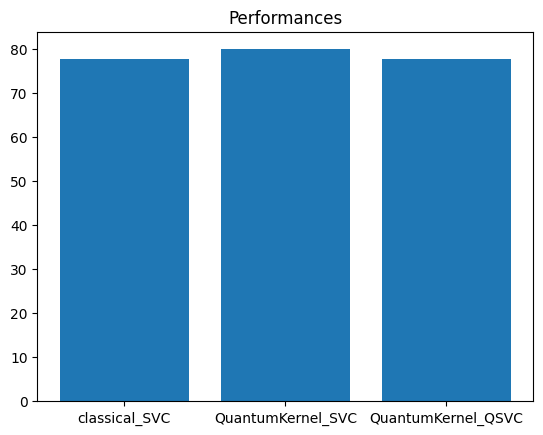

In [26]:
plt.bar(range(len(scores)), [x["score"] for x in scores.values()], tick_label=list(scores.keys()))
plt.title("Performances %")
plt.show()

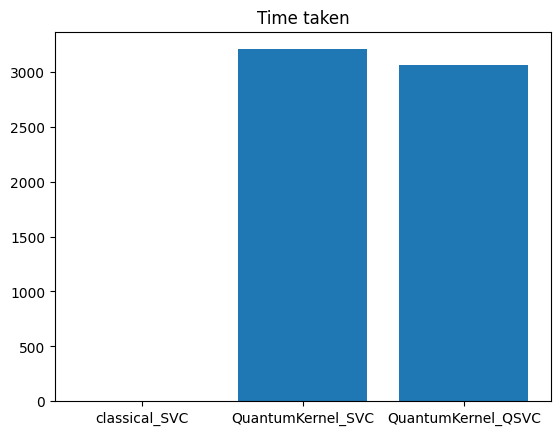

In [27]:
plt.bar(range(len(scores)), [x["time"] for x in scores.values()], tick_label=list(scores.keys()))
plt.title("Time taken (s)")
plt.show()